# PageRank

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

<p style='text-align: justify;'>In the file <b>Stanweb.dat</b>, you will find in compressed form the connectivity matrix for the webpages of Stanford University. Specifically, in the first column are contained the nodes, while in the second the node with which is connected. Using the notation of the paper <b><a href="https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/pagerank/readings/pagerank.pdf">Deeper Inside PageRank</a></b> do the following:</p>

<p style='text-align: justify;'><i>Question 1</i><br>Find the vector $\pi$ with <b><i>i) the Power method</i></b> and <b><i>ii) the Gauss-Seidel method</i></b> as they described in paragraph 5.1 and 5.2 of the tutorial. For both methods consider as $\alpha = 0.85$, stopping criterion $\tau = 10^{-8}$ and the vector $\alpha$ having $1$ if it corresponds to a node with no out links and $0$ otherwise. Are the results the same for both methods? Which method seems to be faster?</p>

<p style='text-align: justify;'><i>Question 2</i><br>Do the previous task with $\alpha=0.99$. Your remarks on the convergence speed. Did the ranking of the first 50 nodes changed?</p>

<p style='text-align: justify;'><i>Question 3</i><br>When we use the power method, do all the components of $\pi$ converge at the same speed to their limits? If not, which of them converge faster: those that correspond to important nodes or to non important? Do you observe the same behavior when you find $\pi$ through the solution of the linear system?</p>

## *Table of Contents*

- [*1. Libraries*](#libraries)
- [*2. Data*](#data)
- [*3. Power Method*](#power_method)
- [*4. Gauss-Seidel Method*](#gauss_seidel_method)
- [*5. Question 1*](#q1)
- [*6. Question 2*](#q2)
- [*7. Question 3*](#q3)

---

## Libraries <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from time import time
from scipy import sparse
from scipy.sparse import identity, csr_matrix
from scipy.sparse.linalg import spsolve_triangular

## Data <a class='anchor' id='data'></a>

##### *Define function to read the data*

In [2]:
# define path and name of the file
filename = './data/stanweb.dat'

def read_connectivity_matrix_file(filename):
    """
    Read connectivity matrix for the webpages of Stanford University
    ________________________________________________________________
    :param filename: the connectivity matrix in compressed form
    :return P: the connectivity matrix
    :return a: the vector a
    ================================================================
    step1: store outbound nodes, inbound nodes and their weights
    step2: calculate the total number of (unique) nodes
    step3: create the (square) connectivity matrix (compressed sparse row matrix)
    step4: create vector a (having 1 if it corresponds to a node with no out links, and 0 otherwise)
    """
    
    # initialize lists to store nodes and weights
    outbound_nodes, inbound_nodes, weights = list(), list(), list()
    
    with open(filename,'r') as f:
        for i in f.readlines():
            # get nodes and weights
            outbound_node, inbound_node, weight = (x for x in i.split())
            # append each element to its respective list
            inbound_nodes.append(int(inbound_node)-1)
            outbound_nodes.append(int(outbound_node)-1)
            weights.append(float(weight))
    
    # get the size of the connectivity matrix
    # mix of unique inbound and outbound nodes
    N = len(set(inbound_nodes) | set(outbound_nodes))
    
    # create the connectivity matrix
    P = csr_matrix((weights,(inbound_nodes,outbound_nodes)), shape=(N,N))
    
    # initialize vector a
    a = np.zeros(N)
    
    # add 1 to the indices where the respective node
    # corresponds to a node with no out links
    a[list(set(inbound_nodes).difference(set(outbound_nodes)))] = 1
    
    # preview
    print(f'P.shape: {P.shape}')
    print(f'a.shape: {a.shape}')
    
    return P, a

# execute function
P, a = read_connectivity_matrix_file(filename)

P.shape: (281903, 281903)
a.shape: (281903,)


## Power Method <a class='anchor' id='power_method'></a>

<p style='text-align: justify;'>In mathematics, <b>power iteration</b> (also known as the <b>power method</b>) is an eigenvalue algorithm: given a diagonalizable matrix $A$, the algorithm will produce a number $\lambda$, which is the greatest (in absolute value) eigenvalue of $A$, and a nonzero vector $v$, which is a corresponding eigenvector of $\lambda$, that is, $Av=\lambda v$. The algorithm is also known as the Von Mises iteration. Power iteration is a very simple algorithm, but it may converge slowly. The most time-consuming operation of the algorithm is the multiplication of matrix $A$ by a vector, so it is effective for a very large sparse matrix with appropriate implementation. - <a href='https://en.wikipedia.org/wiki/Power_iteration'><i>Wikipedia</i></a></p>

For more information, please see the paper **[Deeper Inside PageRank](https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/pagerank/readings/pagerank.pdf)** from Amy N. Langville and Carl D. Meyer, published in October 20, 2004.

#### *Define a function for the Power method*

- $ x^{(k)T} = \alpha x^{(k-1)T} P + (\alpha x^{(k-1)T} a + (1-\alpha))v^T $

In [3]:
def power_method(P, a, alpha, tolerance_level=1e-8):
    """
    Power Method Algorithm, with hyperparameter alpha
    _________________________________________________
    :param P: the connectivity matrix
    :param a: the vector a
    :param alpha: the hyperparameter which defines the trade-off between importance and randomness
    :return pi_new: the π vector
    :return iter_counter: the number of iterations needed for the algorithm to converge
    :return wall_time: the wall time of the algorithm
    :return node_convergence_rate: the rate of convergence
    =================================================
    step1: initialize PageRank vector π, personalized vector v and the convergence rate of each node
    step2: iterate until the ordering of the approximate PageRank vector obtained by the power method converges
    step3: in each iteration compute the relation
            ===> $P = \alpha x^{(k-1)T} P + (\alpha x^{(k-1)T} a + (1-\alpha))v^T$
    """
    
    N = P.shape[0]
    
    # initialize PageRank vector p
    pi_old = pi_new = np.ones(N) / N
    
    # initialize personalized vector v
    v = np.ones(N) / N
    
    # initialize per node convergence rate
    # needed for question 3
    node_convergence_rate = np.zeros(N)
    
    # initialize this constant variable
    # as it will be used in each loop
    const = (1-alpha)*v
    
    def iteration(alpha, P, pi_old, v, const):
        # -----------------------------------------------------------------------------------------------
        # For any starting vector $x^{(0)T}$ (generally, $x^{(0)T} = e^{T}/n$)
        # $P = \alpha x^{(k-1)T} P + (\alpha x^{(k-1)T} a + (1-\alpha))v^T$
        # -----------------------------------------------------------------------------------------------
        p_new = alpha*P.dot(pi_old) + alpha*np.dot(np.dot(a, pi_old), v) + const
        p_new = p_new / np.linalg.norm(p_new, ord=1)
        return p_new
    
    def update_convergence_rate(iter_counter, pi_new, pi_old, node_convergence_rate, tolerance_level):
        # -----------------------------------------------------------------------------------------------
        # A rough estimate of the number of iterations needed to converge to a tolerance level τ,
        # is measured by the residual $x^{(k)T}\bar{\bar{\mathbf{P}}} - x^{(k)T} = x^{(k+1)T} - x^{(k)T}$
        # -----------------------------------------------------------------------------------------------
        residual = np.abs(np.subtract(pi_new, pi_old) / pi_old)
        condition = (residual <= tolerance_level) & (node_convergence_rate == 0)
        node_convergence_rate[condition] = iter_counter
        return node_convergence_rate
    
    iter_counter = 1
    
    # starting time
    start_time = time()
    
    # iterate until the ordering of the approximate PageRank vector π obtained by the power method converges
    while (np.linalg.norm(pi_new-pi_old, ord=1) >= tolerance_level) | (iter_counter == 1):
        pi_old = pi_new.copy()
        pi_new = iteration(alpha, P, pi_old, v, const)
        node_convergence_rate = update_convergence_rate(iter_counter, pi_new, pi_old, node_convergence_rate, tolerance_level)
        iter_counter += 1
        
    # end time
    end_time = time()
    
    # wall time
    wall_time = round((end_time - start_time),1)
    
    # display results
    print(f'PageRank using the Power Method with alpha = {alpha}')
    print('='*55)
    print(f'No Iterations: {iter_counter}')
    print(f'Wall time (s): {wall_time} seconds', end='\n\n')
    
    return pi_new, iter_counter, wall_time, node_convergence_rate

## Gauss-Seidel Method <a class='anchor' id='gauss_seidel_method'></a>

<p style='text-align: justify;'>In numerical linear algebra, the <b>Gauss–Seidel method</b>, also known as the <b>Liebmann method</b> or the <b>method of successive displacement</b>, is an iterative method used to solve a system of linear equations. It is named after the German mathematicians Carl Friedrich Gauss and Philipp Ludwig von Seidel, and is similar to the Jacobi method. Though it can be applied to any matrix with non-zero elements on the diagonals, convergence is only guaranteed if the matrix is either strictly diagonally dominant, or symmetric and positive definite. It was only mentioned in a private letter from Gauss to his student Gerling in 1823. A publication was not delivered before 1874 by Seidel. - <a href='https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method'><i>Wikipedia</i></a></p>

For more information, please see the paper **[Deeper Inside PageRank](https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/pagerank/readings/pagerank.pdf)** from Amy N. Langville and Carl D. Meyer, published in October 20, 2004.

#### *Define a function for the Gauss-Seidel method*
- $ \pi^{T}=(v_{1}^{T}(I-\alpha P_{11})^{-1} | \alpha v_{1}^{T}(I-\alpha P_{11})^{-1} P_{12} + v_{2}^{T}) $

In [4]:
def gauss_seidel_method(P, a, alpha, tolerance_level=1e-8):
    """
    Gauss-Seidel Method Algorithm, with hyperparameter alpha
    ________________________________________________________
    :param P: the connectivity matrix
    :param a: the vector a
    :param alpha: the hyperparameter which defines the trade-off between importance and randomness
    :return pi_new: the π vector
    :return iter_counter: the number of iterations needed for the algorithm to converge
    :return wall_time: the wall time of the algorithm
    :return node_convergence_rate: the rate of convergence
    ========================================================
    step1: initialize PageRank vector π, personalized vector v, the convergence rate of each nodes
    step2: iterate until the ordering of the approximate PageRank vector obtained by the gauss-seidel method converges
    step3: in each iteration compute the relation
            ===> $π^{T} = (v_{1}^{T}(I - αP_{11})^{-1} | αv_{1}^{T}(I - αP_{11})^{-1}P_{12} + v_{2}^{T})$
    """
    
    N = P.shape[0]
    
    # initialize PageRank vector p
    pi_old = pi_new = np.ones(N) / N
    
    # initialize personalized vector v
    v = np.ones(N) / N
    
    # initialize per node convergence rate
    # needed for question 3
    node_convergence_rate = np.zeros(N)
    
    # initialize this constant variable
    # as it will be used in each loop
    const = (1-alpha)*v
    
    # calculate $I - \alpha P$
    M = identity(N) - sparse.tril(alpha*P, k = 0)
    # upper triangular in a sparse format, above main diagonal
    R = sparse.triu(alpha*P, k = 1)
    
    def iteration(M, R, pi_old, alpha, v, const):
        # -----------------------------------------------------------------------------------------------
        # the PageRank vector $π^{T} = v^{T}(I - αP)^{-1}$ can be written as
        # $π^{T} = (v_{1}^{T}(I - αP_{11})^{-1} | αv_{1}^{T}(I - αP_{11})^{-1}P_{12} + v_{2}^{T})$
        # -----------------------------------------------------------------------------------------------
        p_new = spsolve_triangular(M,(R.dot(pi_old) + alpha * v * np.dot(a,pi_old) + const))
        p_new = p_new / np.linalg.norm(p_new, ord=1)
        return p_new
    
    def update_convergence_rate(iter_counter, pi_new, pi_old, node_convergence_rate, tolerance_level):
        # -----------------------------------------------------------------------------------------------
        # A rough estimate of the number of iterations needed to converge to a tolerance level τ,
        # is measured by the residual $x^{(k)T}\bar{\bar{\mathbf{P}}} - x^{(k)T} = x^{(k+1)T} - x^{(k)T}$
        # -----------------------------------------------------------------------------------------------
        residual = np.abs(np.subtract(pi_new, pi_old) / pi_old)
        condition = (residual <= tolerance_level) & (node_convergence_rate == 0)
        node_convergence_rate[condition] = iter_counter
        return node_convergence_rate
    
    iter_counter = 1
    
    # starting time
    start_time = time()
    
    # iterate until the ordering of the approximate PageRank vector π obtained by the power method converges
    while (np.linalg.norm(pi_new-pi_old, ord=1) >= tolerance_level) | (iter_counter == 1):
        pi_old = pi_new.copy()
        pi_new = iteration(M, R, pi_old, alpha, v, const)
        node_convergence_rate = update_convergence_rate(iter_counter, pi_new, pi_old, node_convergence_rate, tolerance_level)
        iter_counter += 1
        
    # end time
    end_time = time()
    
    # wall time
    wall_time = round((end_time - start_time),1)
    
    # display results
    print(f'PageRank using the Gauss-Seidel Method with alpha = {alpha}')
    print('='*55)
    print(f'No Iterations: {iter_counter}')
    print(f'Wall time (s): {wall_time} seconds')
    
    return pi_new, iter_counter, wall_time, node_convergence_rate

## Question 1 <a class='anchor' id='q1'></a>

<p style='text-align: justify;'>Find the vector $\pi$ with <b><i>i) the Power method</i></b> and <b><i>ii) the Gauss-Seidel method</i></b> as they described in paragraph 5.1 and 5.2 of the tutorial. For both methods consider as $\alpha = 0.85$, stopping criterion $\tau = 10^{-8}$ and the vector $\alpha$ having $1$ if it corresponds to a node with no out links and $0$ otherwise. Are the results the same for both methods? Which method seems to be faster?</p>

In [5]:
# execute power method function
pi_vector_pm_85, iters_pm_85, wall_time_pm_85, node_convergence_rate_pm_85 = power_method(P, a, 0.85)

# execute gauss-seidel method function
pi_vector_gs_85, iters_gs_85, wall_time_gs_85, node_convergence_rate_gs_85 = gauss_seidel_method(P, a, 0.85)

PageRank using the Power Method with alpha = 0.85
No Iterations: 92
Wall time (s): 1.6 seconds

PageRank using the Gauss-Seidel Method with alpha = 0.85
No Iterations: 49
Wall time (s): 242.7 seconds


##### *Define function to check if both methods obtained the same results*

In [6]:
def are_the_results_the_same(pi_vector_pm, pi_vector_gs, alpha):
    
    print('Power Method vs Gauss-Seidel Method')
    print('===================================')
    
    def get_top_k_nodes(pi_vector, k):
        top_k_indices = np.argsort(pi_vector)[-k::][::-1]
        return top_k_indices
    
    for k in np.arange(10,60,10):
        # get the top k nodes returned from both methods
        top_k_pm = get_top_k_nodes(pi_vector_pm, k)
        top_k_gs = get_top_k_nodes(pi_vector_gs, k)
        
        # check and print if the results are the same
        print(f'Top {k} nodes: Same results' if np.array_equal(top_k_pm, top_k_gs) else f'Top {k} nodes: Different results')
            
    return

# execute function
_ = are_the_results_the_same(pi_vector_pm_85, pi_vector_gs_85, 0.85)

Power Method vs Gauss-Seidel Method
Top 10 nodes: Same results
Top 20 nodes: Same results
Top 30 nodes: Same results
Top 40 nodes: Different results
Top 50 nodes: Different results


##### *Comments*

- It seems that for an $\alpha$ value of **0.85**, both *Power* method and *Gauss-Seidel* method return the same results for the first 30 nodes
- After that, they start to differentiate
- Also, solving the PageRank problem with the *Power* method took ***92 iterations*** and ***1.6 seconds*** for the algorithm to converge
- On the other hand, even though the *Gauss-Seidel* method needed only ***49 iterations***, it required almost ***150x time***

---

## Question 2 <a class='anchor' id='q2'></a>

<p style='text-align: justify;'>Do the previous task with $\alpha=0.99$. Your remarks on the convergence speed. Did the ranking of the first 50 nodes changed?</p>

In [7]:
# execute power method function
pi_vector_pm_99, iters_pm_99, wall_time_pm_99, node_convergence_rate_pm_99 = power_method(P, a, 0.99)

# execute gauss-seidel method function
pi_vector_gs_99, iters_gs_99, wall_time_gs_99, node_convergence_rate_gs_99 = gauss_seidel_method(P, a, 0.99)

PageRank using the Power Method with alpha = 0.99
No Iterations: 1393
Wall time (s): 35.0 seconds

PageRank using the Gauss-Seidel Method with alpha = 0.99
No Iterations: 610
Wall time (s): 3812.4 seconds


##### *Check if both methods obtained the same results*

In [8]:
# execute function
_ = are_the_results_the_same(pi_vector_pm_99, pi_vector_gs_99, 0.99)

Power Method vs Gauss-Seidel Method
Top 10 nodes: Same results
Top 20 nodes: Different results
Top 30 nodes: Different results
Top 40 nodes: Different results
Top 50 nodes: Different results


##### *Define function to check if the ranking of the first 50 nodes changed for different values of alpha*

In [9]:
def check_ranking_for_same_method_and_different_alpha(method, pi_vector_85, pi_vector_99, k=50):
    
    def get_top_k_nodes(pi_vector, k):
        top_k_indices = np.argsort(pi_vector)[-k::][::-1]
        return top_k_indices
    
    # get the top 50 nodes returned
    # using different values of alpha
    # 0.85 vs 0.99
    top_k_85 = get_top_k_nodes(pi_vector_85, k)
    top_k_99 = get_top_k_nodes(pi_vector_99, k)
    
    # check and print if the arrays of indices of the top 50 nodes are the same
    print(f'PageRank using the {method}' if method == 'Power Method' else f'\nPageRank using the {method}')
    print('='*38)
    print(f'Did the ranking of the first {k} nodes changed for different values of alpha?')
    print(f'Top {k} nodes: Same results' if np.array_equal(top_k_85, top_k_99) else f'Top {k} nodes: Different results')
        
    return

# execute function for both methods
_ = check_ranking_for_same_method_and_different_alpha('Power Method', pi_vector_pm_85, pi_vector_pm_99)
_ = check_ranking_for_same_method_and_different_alpha('Gauss-Seidel Method', pi_vector_gs_85, pi_vector_gs_99)

PageRank using the Power Method
Did the ranking of the first 50 nodes changed for different values of alpha?
Top 50 nodes: Different results

PageRank using the Gauss-Seidel Method
Did the ranking of the first 50 nodes changed for different values of alpha?
Top 50 nodes: Different results


##### *Comments*

- Changing the value of $\alpha$ from **0.85** to **0.99**, not surprisingly, brought some changes in the results
- In particular, *Power* method and *Gauss-Seidel* method return the same results only for the first 10 nodes now
- In addition, we have some major changes in the wall times
- The *Power* method needed, almost, ***1400 iterations*** to converge and it took ***35 seconds***
- The *Gauss-Seidel* method needed ***610 iterations***, but it took ***3812 seconds***.
- Finally, we found that changing the value of $\alpha$ the results for the first 50 nodes changed even when using the same method

---

## Question 3 <a class='anchor' id='q3'></a>

<p style='text-align: justify;'>When we use the power method, do all the components of $\pi$ converge at the same speed to their limits? If not, which of them converge faster: those that correspond to important nodes or to non important? Do you observe the same behavior when you find $\pi$ through the solution of the linear system?</p>

##### *Store the results in a dictionary to use it below*

In [10]:
rates = {'Power Method': [[pi_vector_pm_85, node_convergence_rate_pm_85, 0.85],
                          [pi_vector_pm_99, node_convergence_rate_pm_99, 0.99]],
         'Gauss-Seidel Method': [[pi_vector_gs_85, node_convergence_rate_gs_85, 0.85],
                                 [pi_vector_gs_99, node_convergence_rate_gs_99, 0.99]]}

##### *Define function to check and visualize the convergence rate of the nodes for both methods*

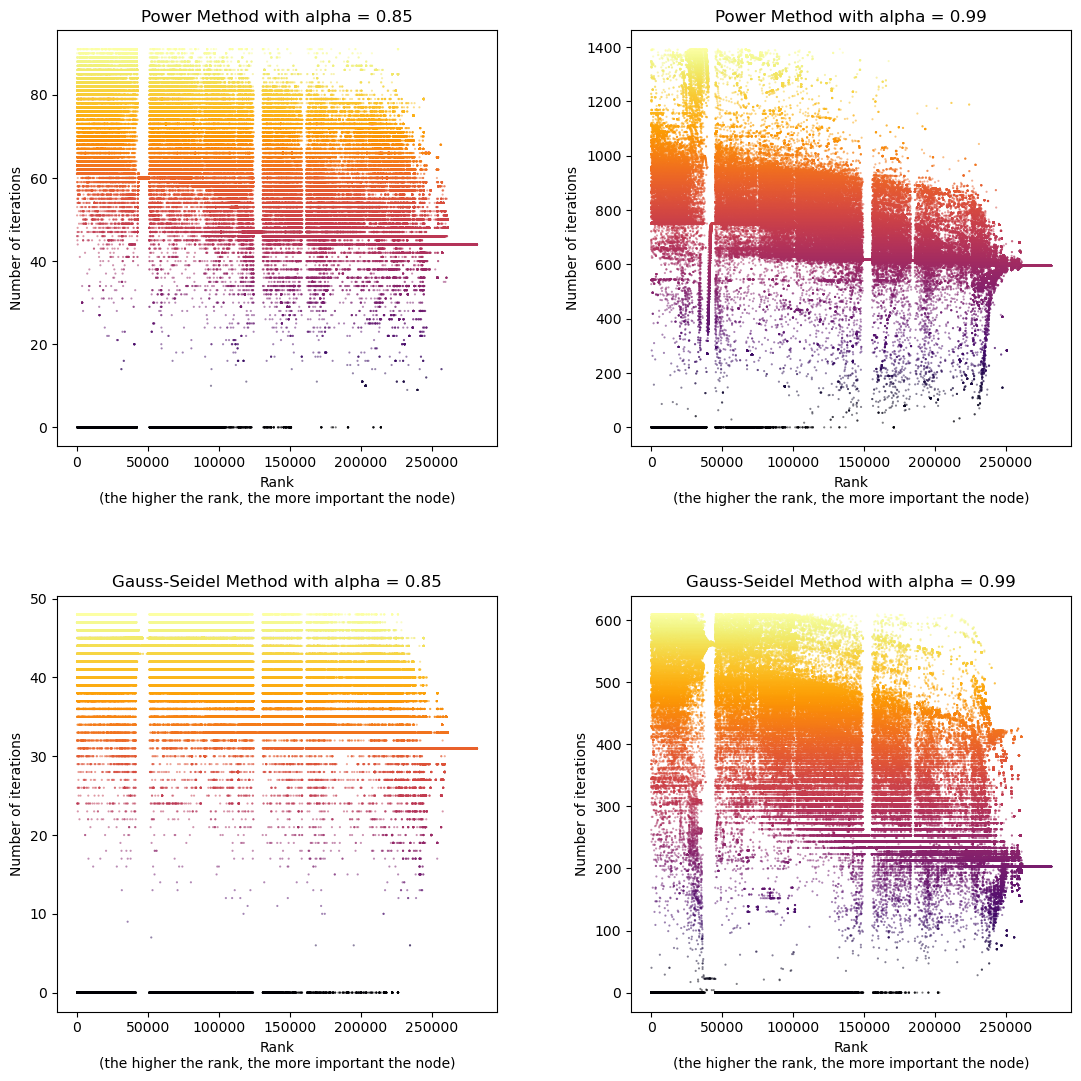

In [11]:
def plot_convergence_rates(rates):
    
    # create figure
    fig, ax = plt.subplots(2,2,figsize=(12,12),dpi=100,facecolor='white')
    
    # loop through methods
    for i, (key, (method_alpha_85, method_alpha_99)) in enumerate(rates.items()):

        # plot power method convergence rate
        conv_rate_85 = method_alpha_85[1][np.argsort(method_alpha_85[0])[::-1]]
        ax[i,0].scatter(range(0,len(method_alpha_85[0])), conv_rate_85, s=0.3, alpha=0.5, cmap='inferno', c=conv_rate_85)
        ax[i,0].set_xlabel('Rank\n(the higher the rank, the more important the node)')
        ax[i,0].set_ylabel('Number of iterations')
        ax[i,0].set_title(f'{key} with alpha = {method_alpha_85[2]}')
        
        # plot gauss-seidel convergence rate
        conv_rate_99 = method_alpha_99[1][np.argsort(method_alpha_99[0])[::-1]]
        ax[i,1].scatter(range(0,len(method_alpha_99[0])), conv_rate_99, s=0.3, alpha=0.5, cmap='inferno', c=conv_rate_99)
        ax[i,1].set_xlabel('Rank\n(the higher the rank, the more important the node)')
        ax[i,1].set_ylabel('Number of iterations')
        ax[i,1].set_title(f'{key} with alpha = {method_alpha_99[2]}')

    plt.tight_layout(pad=5)
    fig.savefig('./images/convergences_rates.svg')
    plt.show()
    
    return

# execute function
_ = plot_convergence_rates(rates)

##### *Define function to display how many iterations are needed for the most important nodes to converge*

In [12]:
def iterations_needed_for_convergence(rates, k=10):
    
    # loop through methods
    for i, (key, (method_alpha_85, method_alpha_99)) in enumerate(rates.items()):
        
        # find the top k most import nodes
        # and their convergence rate
        # for alpha = 0.85
        k_important_nodes = method_alpha_85[0].argsort()[::-1][:k]
        iterations_needed = method_alpha_85[1][k_important_nodes]
        
        # display results
        print(f'{key} with alpha = {method_alpha_85[2]}')
        print('='*37)
        print(f'Average node convergence rate: {int(method_alpha_85[1].mean())} iterations')
        print(f'Iterations needed by the {k} most important nodes: {iterations_needed}', end='\n\n')
        
        # find the top k most import nodes
        # and their convergence rate
        # for alpha = 0.99
        k_important_nodes = method_alpha_99[0].argsort()[::-1][:k]
        iterations_needed = method_alpha_99[1][k_important_nodes]
        
        # display results
        print(f'{key} with alpha = {method_alpha_99[2]}')
        print('='*37)
        print(f'Average node convergence rate: {int(method_alpha_99[1].mean())} iterations')
        print(f'Iterations needed by the {k} most important nodes: {iterations_needed}', end='\n\n')
        
    return

# execute function
_ = iterations_needed_for_convergence(rates)

Power Method with alpha = 0.85
Average node convergence rate: 55 iterations
Iterations needed by the 10 most important nodes: [82. 78. 75. 84. 72. 77. 61. 61. 76. 66.]

Power Method with alpha = 0.99
Average node convergence rate: 690 iterations
Iterations needed by the 10 most important nodes: [ 866. 1346.  957.  942.  890.  959.  868.  751.  751. 1227.]

Gauss-Seidel Method with alpha = 0.85
Average node convergence rate: 34 iterations
Iterations needed by the 10 most important nodes: [47. 33. 43. 48. 42. 35. 47. 47. 40. 39.]

Gauss-Seidel Method with alpha = 0.99
Average node convergence rate: 328 iterations
Iterations needed by the 10 most important nodes: [463.   0. 588. 499. 475. 588. 463. 594. 594.   0.]



##### *Comments*

<p style='text-align: justify;'>In general, higher ranked nodes need on average more iterations to converge than lower ranked nodes. The reason for this is that the lower ranked nodes have more outbound links than inbound links, resulting in their pagerank converging relatively quickly. On the other hand, higher ranked nodes tend to have many inbound links, which increases their pagerank until it converges. And this makes perfect sense if we consider, again, what PageRank is, in fact, and how it works. PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.</p>

---

*Thank you!*

---